# Step 0: User-Based Collaborative Filtering Recommendation Algorithm

Firstly, let's understand how User-based collaborative filtering works.

User-based collaborative filtering makes recommendations based on user-product interactions in the past. The assumption behind the algorithm is that similar users like similar products.

User-based collaborative filtering algorithm usually has the following steps:

1. Find similar users based on interactions with common items.
2. Identify the items rated high by similar users but have not been exposed to the active user of interest.
3. Calculate the weighted average score for each item.
4. Rank items based on the score and pick top n items to recommend.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Step 1: Import Python Libraries

In the first step, we will import Python libraries `pandas`, `numpy`, and `scipy.stats`. These three libraries are for data processing and calculations.

We also imported `seaborn` for visualization and `cosine_similarity` for calculating similarity score.

In [6]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
!unzip "/content/ml-latest-small.zip"

Archive:  /content/ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


There are multiple datasets in the 100k movielens folder. For this tutorial, we will use two ratings and movies.

Now let's read in the rating data.

In [7]:
# Read in data
ratings=pd.read_csv('/content/ml-latest-small/ratings.csv')

# Take a look at the data
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


There are four columns in the ratings dataset, userID, movieID, rating, and timestamp.

The dataset has over 100k records, and there is no missing data.

In [8]:
# Get the dataset information
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


The 100k ratings are from 610 users on 9724 movies. The rating has ten unique values from 0.5 to 5.

In [9]:
# Number of users
print('The ratings dataset has', ratings['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', ratings['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', ratings['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings['rating'].unique()))

The ratings dataset has 610 unique users
The ratings dataset has 9724 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [10]:
# Read in data
movies = pd.read_csv('ml-latest-small/movies.csv')

# Take a look at the data
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


#Using 'movieID' as the matching key, i have merged the data into a single data frame

In [11]:
merge_data=pd.merge(ratings, movies, on='movieId', how='inner')

In [12]:
merge_data.head(10)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
5,18,1,3.5,1455209816,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
6,19,1,4.0,965705637,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
7,21,1,3.5,1407618878,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
8,27,1,3.0,962685262,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
9,31,1,5.0,850466616,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [15]:
agg_ratings = merge_data.groupby('title').agg(average_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

In [16]:
agg_ratings

,title,average_rating,number_of_ratings
0,'71 (2014),4.000000,1
1,'Hellboy': The Seeds of Creation (2004),4.000000,1
2,'Round Midnight (1986),3.500000,2
3,'Salem's Lot (2004),5.000000,1
4,'Til There Was You (1997),4.000000,2
...,...,...,...
9714,eXistenZ (1999),3.863636,22
9715,xXx (2002),2.770833,24
9716,xXx: State of the Union (2005),2.000000,5
9717,¡Three Amigos! (1986),3.134615,26


In [18]:
## here we can see maximum ratings of a book is 329,means some books have got rated by 329 people
max(agg_ratings['number_of_ratings'])

329

## lets first try with popularity based recommendation system
Imagine you're in a library, surrounded by countless books on the shelves. You're not sure which book to pick and read next. Then, you notice that there's one book that many people seem to be borrowing and talking about. They say it's a captivating and enjoyable read.

Based on this buzz and the fact that so many people are interested in that book, you become curious. You think to yourself, "If so many people are loving it, maybe I should give it a try too."

That's how popularity book recommendation works. It suggests books that are popular and widely read among a large number of people. The recommendation system takes into account the books that are in high demand, frequently borrowed, or positively reviewed by many readers.

The idea behind popularity book recommendation is that if a book has gained significant attention and praise from a broad audience, it's likely to be a worthwhile read for you too. It's like joining a reading trend and exploring a book that has captured the interest and enjoyment of many others.

Below code filters the 'popular_df' dataframe to include only movies with a minimum of 100 ratings, sorts them based on their average ratings in descending order, and finally selects the top 50 books with the highest average ratings. This helps us to identify the most popular books with high ratings among those that have received a significant number of ratings.

In [24]:
popular_movies = agg_ratings[agg_ratings['number_of_ratings'] >=100].sort_values('average_rating', ascending=False).head(100)

In [25]:
popular_movies

,title,average_rating,number_of_ratings
7593,"Shawshank Redemption, The (1994)",4.429022,317
3499,"Godfather, The (1972)",4.289062,192
3011,Fight Club (1999),4.272936,218
3500,"Godfather: Part II, The (1974)",4.259690,129
2334,"Departed, The (2006)",4.252336,107
...,...,...,...
8644,There's Something About Mary (1998),3.676190,105
713,Babe (1995),3.652344,128
7205,"Rock, The (1996)",3.640496,121
4345,Indiana Jones and the Temple of Doom (1984),3.638889,108


##so above u can see the puplular movies ,this is how the popularity based recommenation system works

# Step 3: Exploratory Data Analysis (EDA)

In step 3, we need to filter the movies and keep only those with over 100 ratings for the analysis. This is to make the calculation manageable by the Google Colab memory.

To do that, we first group the movies by title, count the number of ratings, and keep only the movies with greater than 100 ratings.

The average ratings for the movies are calculated as well.

From the `.info()` output, we can see that there are 134 movies left.

In [26]:
# Aggregate by movie
# agg_ratings = merge_data.groupby('title').agg(mean_rating = ('rating', 'mean'),
#                                                 number_of_ratings = ('rating', 'count')).reset_index()

# # Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 74 to 9615
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              134 non-null    object 
 1   average_rating     134 non-null    float64
 2   number_of_ratings  134 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB


Let's check what the most popular movies and their ratings are.

In [27]:
# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,average_rating,number_of_ratings
3158,Forrest Gump (1994),4.164134,329
7593,"Shawshank Redemption, The (1994)",4.429022,317
6865,Pulp Fiction (1994),4.197068,307
7680,"Silence of the Lambs, The (1991)",4.161290,279
5512,"Matrix, The (1999)",4.192446,278


Next, let's use a `jointplot` to check the correlation between the average rating and the number of ratings.

We can see an upward trend from the scatter plot, showing that popular movies get higher ratings.

The average rating distribution shows that most movies in the dataset have an average rating of around 4.

The number of rating distribution shows that most movies have less than 150 ratings.

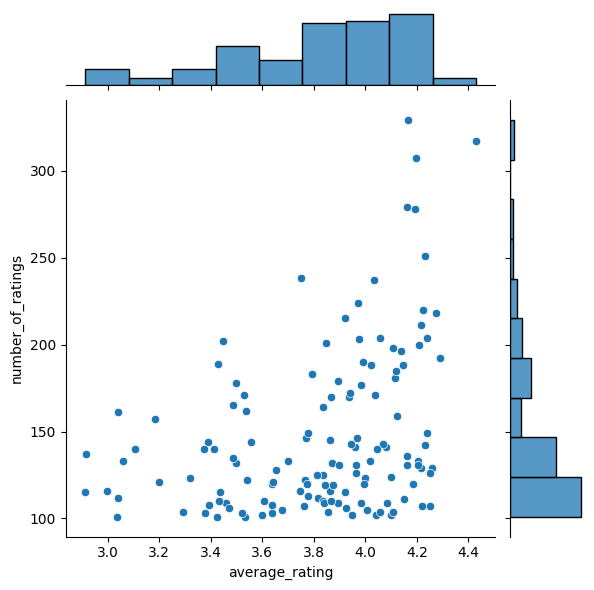

In [28]:
# Visulization
sns.jointplot(x='average_rating', y='number_of_ratings', data=agg_ratings_GT100)

To keep only the 134 movies with more than 100 ratings, we need to join the movie with the user-rating level dataframe.

`how='inner'` and `on='title'` ensure that only the movies with more than 100 ratings are included.

In [31]:
# Merge data
df_GT100 = pd.merge(merge_data, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19788 entries, 0 to 19787
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     19788 non-null  int64  
 1   movieId    19788 non-null  int64  
 2   rating     19788 non-null  float64
 3   timestamp  19788 non-null  int64  
 4   title      19788 non-null  object 
 5   genres     19788 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ MB


In [32]:
final_data=df_GT100

After filtering the movies with over 100 ratings, we have 597 users that rated 134 movies.

In [34]:
# Number of users
print('The ratings dataset has', final_data['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', final_data['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', final_data['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(final_data['rating'].unique()))

The ratings dataset has 597 unique users
The ratings dataset has 134 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


# Step 4: Create User-Movie Matrix

In step 4, we will transform the dataset into a matrix format. The rows of the matrix are users, and the columns of the matrix are movies. The value of the matrix is the user rating of the movie if there is a rating. Otherwise, it shows 'NaN'.

In [35]:
# Create user-item matrix
matrix = final_data.pivot_table(index='userId', columns='title', values='rating')
matrix.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,4.0,NaN,NaN,5.0,5.0,NaN,4.0,...,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN,5.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN
5,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


# Step 5: Data Normalization

Since some people tend to give a higher rating than others, we normalize the rating by extracting the average rating of each user.

After normalization, the movies with a rating less than the user's average rating get a negative value, and the movies with a rating more than the user's average rating get a positive value.

In [36]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,-0.392857,NaN,NaN,0.607143,0.607143,NaN,-0.392857,...,NaN,NaN,NaN,-1.392857,NaN,0.607143,NaN,NaN,0.607143,0.607143
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.617647,NaN,NaN,NaN,1.617647,NaN,NaN,NaN,...,NaN,NaN,-1.382353,NaN,NaN,NaN,NaN,NaN,0.617647,NaN
5,NaN,-0.461538,0.538462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.461538,NaN,NaN,NaN,NaN,0.538462,NaN,NaN,NaN,NaN


# Step 6: Identify Similar Users

There are different ways to measure similarities. Pearson correlation and cosine similarity are two widely used methods.

In this tutorial, we will calculate the user similarity matrix using Pearson correlation.

In [40]:
# User similarity matrix using Pearson correlation
pearson_similarity = matrix_norm.T.corr()


In [41]:
pearson_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.391797,0.180151,-0.439941,-0.029894,0.464277,1.0,-0.037987,...,0.091574,0.254514,0.101482,-0.500000,0.780020,0.303854,-0.012077,0.242309,-0.175412,0.071553
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,-0.583333,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.765641
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.391797,NaN,NaN,1.000000,-0.394823,0.421927,0.704669,0.055442,NaN,0.360399,...,-0.239325,0.562500,0.162301,-0.158114,0.905134,0.021898,-0.020659,-0.286872,NaN,-0.050868
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,0.328889,0.030168,NaN,-0.777714,...,0.000000,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582


Those who are interested in using cosine similarity can refer to this code. Since `cosine_similarity` does not take missing values, we need to impute the missing values with 0s before the calculation.

In [44]:
# User similarity matrix using cosine similarity
cosines_similarity= cosine_similarity(matrix_norm.fillna(0))
cosines_similarity

array([[ 1.        ,  0.        ,  0.        , ...,  0.14893867,
        -0.06003146,  0.04528224],
       [ 0.        ,  1.        ,  0.        , ..., -0.04485403,
        -0.25197632,  0.18886414],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.14893867, -0.04485403,  0.        , ...,  1.        ,
         0.14734568,  0.07931015],
       [-0.06003146, -0.25197632,  0.        , ...,  0.14734568,
         1.        , -0.14276787],
       [ 0.04528224,  0.18886414,  0.        , ...,  0.07931015,
        -0.14276787,  1.        ]])

Now let's use user ID 1 as an example to illustrate how to find similar users.

We first need to exclude user ID 1 from the similar user list and decide the number of similar users.



In [45]:
# Pick a user ID
user_id = 1

# Remove picked user ID from the candidate list
pearson_similarity.drop(index=user_id, inplace=True)

# Take a look at the data
pearson_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,-0.583333,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.765641
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.391797,NaN,NaN,1.000000,-0.394823,0.421927,0.704669,0.055442,NaN,0.360399,...,-0.239325,0.562500,0.162301,-0.158114,0.905134,0.021898,-0.020659,-0.286872,NaN,-0.050868
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,0.328889,0.030168,NaN,-0.777714,...,0.000000,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582
6,-0.439941,NaN,NaN,0.421927,-0.006888,1.000000,0.000000,-0.127385,NaN,0.957427,...,-0.292770,-0.030599,-0.123983,-0.176327,0.063861,-0.468008,0.541386,-0.337129,0.158255,-0.030567


In the user similarity matrix, the values range from -1 to 1, where -1 means opposite movie preference and 1 means same movie preference.

`n = 10` means we would like to pick the top 10 most similar users for user ID 1.

The user-based collaborative filtering makes recommendations based on users with similar tastes, so we need to set a positive threshold. Here we set the `user_similarity_threshold` to be 0.3, meaning that a user must have a Pearson correlation coefficient of at least 0.3 to be considered as a similar user.

After setting the number of similar users and similarity threshold, we sort the user similarity value from the highest and lowest, then printed out the most similar users' ID and the Pearson correlation value.



In [52]:
def similar_user(user_id,n):
  threshold=.4
  sim_users=imilar_users = pearson_similarity[pearson_similarity[user_id]>threshold][user_id].sort_values(ascending=False)[:n]
  return sim_users
  print(f'The similar users for user {user_id} are', sim_users)

In [53]:
simi_users=similar_user(1,10)

# Step 7: Narrow Down Item Pool

In step 7, we will narrow down the item pool by doing the following:
1. Remove the movies that have been watched by the target user (user ID 1 in this example).
2. Keep only the movies that similar users have watched.

To remove the movies watched by the target user, we keep only the row for `userId=1` in the user-item matrix and remove the items with missing values.

In [48]:
def watched_moviews(user_id):
  picked_userid_watched = matrix_norm[matrix_norm.index == user_id].dropna(axis=1, how='all')
  return picked_userid_watched




In [61]:
#watched moviews by id=1
watched_user=watched_moviews(1)

To keep only the similar users' movies, we keep the user IDs in the top 10 similar user lists and remove the film with all missing values. All missing value for a movie means that none of the similar users have watched the movie.


In [54]:
def similar_users_moview(id):
  similar_user_movies = matrix_norm[matrix_norm.index.isin(simi_users.index)].dropna(axis=1, how='all')
  return similar_user_movies


In [60]:
#similar user and similar moview watched
#Movies that similar users watched. Remove movies that none of the similar users have watched
similar=similar_users_moview(1)

In [69]:
similar

title,Aladdin (1992),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Batman Begins (2005),"Beautiful Mind, A (2001)",Beauty and the Beast (1991),Blade Runner (1982),"Bourne Identity, The (2002)","Breakfast Club, The (1985)",Catch Me If You Can (2002),"Dark Knight, The (2008)",...,"Monsters, Inc. (2001)",Ocean's Eleven (2001),Pirates of the Caribbean: The Curse of the Black Pearl (2003),"Shawshank Redemption, The (1994)",Shrek (2001),Spider-Man (2002),Terminator 2: Judgment Day (1991),Titanic (1997),Up (2009),WALL·E (2008)
userId,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,0.466667,NaN,0.466667,NaN,0.466667,NaN,-0.533333,0.466667,NaN,...,NaN,NaN,NaN,NaN,NaN,0.466667,NaN,-0.533333,NaN,NaN
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,NaN
366,NaN,NaN,-0.205882,NaN,NaN,NaN,NaN,NaN,NaN,-0.205882,...,NaN,NaN,-0.205882,NaN,NaN,NaN,-0.205882,NaN,NaN,NaN
401,-0.382353,NaN,NaN,NaN,-0.382353,NaN,NaN,NaN,NaN,NaN,...,0.117647,NaN,0.117647,NaN,0.117647,NaN,NaN,NaN,0.617647,0.617647
502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.125000,NaN,NaN,NaN,NaN,NaN,NaN
511,NaN,-0.653846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.346154,NaN,-1.153846,NaN,NaN,-0.153846,NaN
550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.277778,-0.277778,...,NaN,NaN,NaN,0.222222,NaN,NaN,NaN,NaN,0.222222,-0.277778
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
# similar_user_movies = matrix_norm[matrix_norm.index.isin(simi_users.index)].dropna(axis=1, how='all')
# watched_similar_user=similar_user_movies

Next, we will drop the movies that user ID 1 watched from the similar user movie list. `errors='ignore'` drops columns if they exist without giving an error message.

In [70]:
# Remove the watched movie from the movie list
similar.drop(watched_user.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar

title,Aladdin (1992),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Batman Begins (2005),"Beautiful Mind, A (2001)",Beauty and the Beast (1991),Blade Runner (1982),"Bourne Identity, The (2002)","Breakfast Club, The (1985)",Catch Me If You Can (2002),"Dark Knight, The (2008)",...,"Monsters, Inc. (2001)",Ocean's Eleven (2001),Pirates of the Caribbean: The Curse of the Black Pearl (2003),"Shawshank Redemption, The (1994)",Shrek (2001),Spider-Man (2002),Terminator 2: Judgment Day (1991),Titanic (1997),Up (2009),WALL·E (2008)
userId,,,,,,,,,,,,,,,,,,,,,
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,NaN,0.466667,NaN,0.466667,NaN,0.466667,NaN,-0.533333,0.466667,NaN,...,NaN,NaN,NaN,NaN,NaN,0.466667,NaN,-0.533333,NaN,NaN
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.214286,NaN
366,NaN,NaN,-0.205882,NaN,NaN,NaN,NaN,NaN,NaN,-0.205882,...,NaN,NaN,-0.205882,NaN,NaN,NaN,-0.205882,NaN,NaN,NaN
401,-0.382353,NaN,NaN,NaN,-0.382353,NaN,NaN,NaN,NaN,NaN,...,0.117647,NaN,0.117647,NaN,0.117647,NaN,NaN,NaN,0.617647,0.617647
502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.125000,NaN,NaN,NaN,NaN,NaN,NaN
511,NaN,-0.653846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.346154,NaN,-1.153846,NaN,NaN,-0.153846,NaN
550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.277778,-0.277778,...,NaN,NaN,NaN,0.222222,NaN,NaN,NaN,NaN,0.222222,-0.277778
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 8: Recommend Items

In step 8, we will decide which movie to recommend to the target user. The recommended items are determined by the weighted average of user similarity score and movie rating. The movie ratings are weighted by the similarity scores, so the users with higher similarity get higher weights.

This code loops through items and users to get the item score, rank the score from high to low and pick the top 10 movies to recommend to user ID 1.

In [98]:

def recommend_items(n,item_score):
  for i in similar.columns:
    rating=similar[i]
    s=0
    cnt=0;
    for u in simi_users.index:
      if(pd.isna(rating[u])==False):
        s+=(simi_users[u]*rating)
        cnt+=1
    item_score[i]=s/cnt
  item_score=pd.DataFrame(item_score.items(),columns=['movie_name','movie_score'])





In [101]:
item_score={}
recommend_items(10,item_score)
item_score=pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])

In [ ]:

top_items=item_score.sort_values(by='movie_score',ascending=False)

In [111]:
# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar.columns:
  # Get the ratings for movie i
  movie_rating = similar[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in simi_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = simi_users[u] * movie_rating[u]

      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])

# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

m = 10
ranked_item_score.head(m)

,movie,movie_score
16,Harry Potter and the Chamber of Secrets (2002),1.888889
13,Eternal Sunshine of the Spotless Mind (2004),1.888889
6,"Bourne Identity, The (2002)",0.888889
29,Ocean's Eleven (2001),0.888889
18,Inception (2010),0.587491
3,"Beautiful Mind, A (2001)",0.466667
5,Blade Runner (1982),0.466667
12,Donnie Darko (2001),0.466667
10,"Departed, The (2006)",0.256727
31,"Shawshank Redemption, The (1994)",0.222566


for finding the rating of

# Step 9: Predict Scores (Optional)

If the goal is to choose the recommended items, having the rank of the items is enough. However, if the goal is to predict the user's rating, we need to add the user's average movie rating score back to the movie score.

In [112]:
# Average rating for the picked user
avg_rating = matrix[matrix.index == user_id].T.mean()[user_id]

# Print the average movie rating for user 1
print(f'The average movie rating for user {user_id} is {avg_rating:.2f}')

The average movie rating for user 1 is 4.39


In [113]:
rating_x=matrix[matrix.index == user_id].T.mean()[user_id]

The average movie rating for user 1 is 4.39, so we add 4.39 back to the movie score.

In [114]:
# Calcuate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating

# Take a look at the data
ranked_item_score.head(m)

,movie,movie_score,predicted_rating
16,Harry Potter and the Chamber of Secrets (2002),1.888889,6.281746
13,Eternal Sunshine of the Spotless Mind (2004),1.888889,6.281746
6,"Bourne Identity, The (2002)",0.888889,5.281746
29,Ocean's Eleven (2001),0.888889,5.281746
18,Inception (2010),0.587491,4.980348
3,"Beautiful Mind, A (2001)",0.466667,4.859524
5,Blade Runner (1982),0.466667,4.859524
12,Donnie Darko (2001),0.466667,4.859524
10,"Departed, The (2006)",0.256727,4.649584
31,"Shawshank Redemption, The (1994)",0.222566,4.615423


In [115]:
rating=ranked_item_score['predicted_rating'].mean()
def recommend(rating):
  recomd=ranked_item_score[ranked_item_score['predicted_rating']>rating]['movie']
  return recomd

In [116]:
recommend(rating)

16       Harry Potter and the Chamber of Secrets (2002)
13         Eternal Sunshine of the Spotless Mind (2004)
6                           Bourne Identity, The (2002)
29                                Ocean's Eleven (2001)
18                                     Inception (2010)
3                              Beautiful Mind, A (2001)
5                                   Blade Runner (1982)
12                                  Donnie Darko (2001)
10                                 Departed, The (2006)
31                     Shawshank Redemption, The (1994)
36                                            Up (2009)
19                              Incredibles, The (2004)
15                             Good Will Hunting (1997)
17    Harry Potter and the Sorcerer's Stone (a.k.a. ...
37                                        WALL·E (2008)
14                                  Finding Nemo (2003)
22                                Lion King, The (1994)
28                                Monsters, Inc.

We can see that the top 10 recommended movies all have predicted ratings greater than 4.5.

# Summary


* What is user-based (user-user) collaborative filtering?
* How to create a user-product matrix?
* How to process data for user-based collaborative filtering?
* How to identify similar users?
* How to narrow down the items pool?
* How to rank items for the recommendation?
* How to predict the rating score?


# References

* [User-Based Collaborative Filtering](https://www.geeksforgeeks.org/user-based-collaborative-filtering/)